/Users/erikafox/opt/miniconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
2023-05-03 18:49:27.266908: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


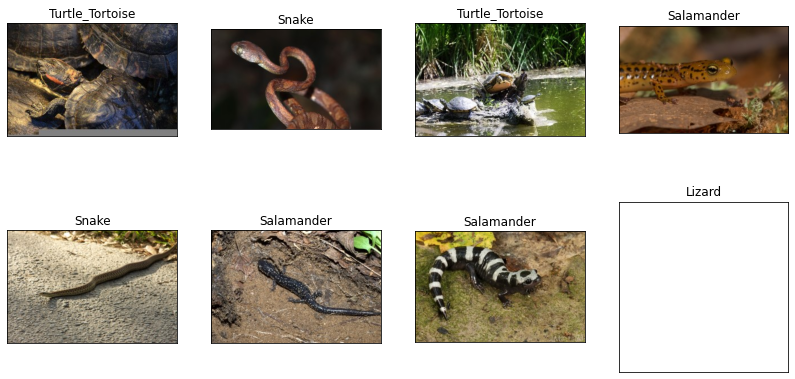

In [1]:
import cv2
import numpy as np
import pandas as pd
import os
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Flatten, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.optimizers import Adam
import seaborn as sns
from PIL import Image
from sklearn.metrics import confusion_matrix
from random import choice,sample
from ipynb.fs.full.create_dataframe import read_data

from ipynb.fs.full.gen_atlas_data import gen_pairs
from sklearn.metrics import roc_curve, auc

In [2]:
def basic_preprocess(dataframe):
    # Basic preprocessing 
    dataframe=dataframe[dataframe.astype(str)['image'] != '[]']
    # prepare X
    img_list = list(dataframe['image'])
    data_img = []
    for each in img_list:
                each_img = cv2.cvtColor(each, cv2.COLOR_BGR2RGB)
                #Resize the images:
                each_img_resized = cv2.resize(each_img, (128,128))
                #Save arrays to a list:


                
                data_img.append(each_img_resized)
    # Converting list to numpy array
    X = np.array(data_img)

    # prepare y
    y = OneHotEncoder(dtype='int8', sparse=False).fit_transform(dataframe['target'].values.reshape(-1,1))

    return X,y

def fit_model(X_train,y_train,X_val,y_val):
    #  code adapted from:
    #  https://pub.towardsai.net/multiclass-image-classification-hands-on-with-keras-and-tensoflow-e1cf434f3467


    train_gen = ImageDataGenerator(horizontal_flip=True,
                               rotation_range = 45,
                               zoom_range=0.2,
                               height_shift_range = 0.5,
                               width_shift_range = 0.5)
    validation_gen = ImageDataGenerator(horizontal_flip=True,
                                    rotation_range = 45,
                                    zoom_range=0.2,
                                    height_shift_range = 0.5,
                                    width_shift_range = 0.5)
    train_gen.fit(X_train)
    validation_gen.fit(X_val)
    batch_size = 64
    epochs = 10
    base = Xception(include_top=False, 
                weights='imagenet', 
                input_shape=(128,128,3))
    x = base.output
    x = GlobalAveragePooling2D()(x)
    head = Dense(y_train.shape[1], activation='softmax')(x)
    model = Model(inputs=base.input, outputs=head)
    model.compile(optimizer=Adam(learning_rate=0.0001),
              loss = 'categorical_crossentropy',
              metrics=['accuracy'], run_eagerly=True)
    
    fit = model.fit_generator(
               train_gen.flow(X_train, y_train,
               batch_size=batch_size),
               epochs = epochs,
               validation_data = validation_gen.flow(X_val, y_val)
)

    return model,fit

In [3]:
class Illumination(tf.keras.layers.Layer):
    def __init__(self, is_train=False):
        super(Illumination, self).__init__()
        self.is_train = is_train

    def build(self, input_shape):
        # initialize illumination weight with 0 mean 0.05 std
        initializer = tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.05)
        
        self.illumination = tf.keras.layers.Conv2D(filters=1, kernel_size=(1,1), 
                                                   activation=None, 
                                                   kernel_initializer=initializer,
                                                   trainable=self.is_train)

    def call(self, inputs):
        # Apply 1x1 convolution to input tensor to get illumination
        illumination = self.illumination(inputs)
        # Return illumination tensor
        return illumination




def fit_model2(X_train,y_train,X_val,y_val):
    image_size = X_train[0].shape
    model = tf.keras.models.Sequential([ 
    tf.keras.layers.Conv2D(filters=32, kernel_size=(3,3), activation='relu', input_shape=image_size),
    tf.keras.layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu'),
    tf.keras.layers.Conv2D(filters=128, kernel_size=(3,3), activation='relu'),
    tf.keras.layers.Conv2D(filters=256, kernel_size=(3,3), activation='relu'),
    Illumination(is_train=True),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=128, activation='relu'),
    tf.keras.layers.Dense(y_train.shape[1], activation='softmax')])
    model.summary()


    model.compile(optimizer=Adam(learning_rate=0.0001),
              loss = 'categorical_crossentropy',
              metrics=['accuracy'], run_eagerly=True)
    

    fit = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_val, y_val))

    return model,fit

In [4]:
def bright_contrast (image, alpha=1.5, beta=50):
    return cv2.convertScaleAbs(image, alpha=alpha, beta=beta)

In [5]:
# create dataframe using other file's code
# create dataframe using other file's code
reptiles=read_data(["Crocodile_Alligator","Gecko"])
pair_data=gen_pairs(2800,reptiles)
reptiles=pair_data

reptiles.target.value_counts()

Lizard             607
Turtle_Tortoise    568
Salamander         556
Frog_Toad          541
Snake              528
Name: target, dtype: int64

In [6]:
reptiles["image"]=reptiles["image"].apply(lambda x: bright_contrast(x))

In [7]:
X,y= basic_preprocess(reptiles) ## replace this to change preprocessing

X_data, X_test, y_data, y_test = train_test_split(X, y, test_size=0.15, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_data, y_data, test_size=0.2, random_state=42)

print('X_train shape: ', X_train.shape)
print('y_train shape: ', y_train.shape)
print('X_val shape  : ', X_val.shape)
print('y_val shape  : ', y_val.shape)
print('X_test shape : ', X_test.shape)
print('y_test shape : ', y_test.shape)

X_train shape:  (1904, 128, 128, 3)
y_train shape:  (1904, 5)
X_val shape  :  (476, 128, 128, 3)
y_val shape  :  (476, 5)
X_test shape :  (420, 128, 128, 3)
y_test shape :  (420, 5)


In [8]:
X[1].shape

(128, 128, 3)

In [9]:
model,fit=fit_model(X_train,y_train,X_val,y_val)

2023-05-03 18:50:03.632805: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
/var/folders/5b/sjkc4b8n0hs41zd03hxr66100000gn/T/ipykernel_21758/1547156176.py:54: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  fit = model.fit_generator(


Epoch 1/10
30/30 [==============================] - 250s 8s/step - loss: 1.5632 - accuracy: 0.3025 - val_loss: 1.7331 - val_accuracy: 0.2080
Epoch 2/10
30/30 [==============================] - 159s 5s/step - loss: 1.3547 - accuracy: 0.4496 - val_loss: 1.6263 - val_accuracy: 0.2710
Epoch 3/10
30/30 [==============================] - 162s 5s/step - loss: 1.2107 - accuracy: 0.5257 - val_loss: 1.4557 - val_accuracy: 0.3971
Epoch 4/10
30/30 [==============================] - 166s 6s/step - loss: 1.0706 - accuracy: 0.5888 - val_loss: 1.2795 - val_accuracy: 0.5000
Epoch 5/10
30/30 [==============================] - 161s 5s/step - loss: 0.9437 - accuracy: 0.6423 - val_loss: 1.2309 - val_accuracy: 0.5336
Epoch 6/10
30/30 [==============================] - 168s 6s/step - loss: 0.8775 - accuracy: 0.6633 - val_loss: 1.2644 - val_accuracy: 0.5714
Epoch 7/10
30/30 [==============================] - 159s 5s/step - loss: 0.7884 - accuracy: 0.6959 - val_loss: 1.0097 - val_accuracy: 0.6450
Epoch 8/10
30

14/14 [==============================] - 11s 802ms/step


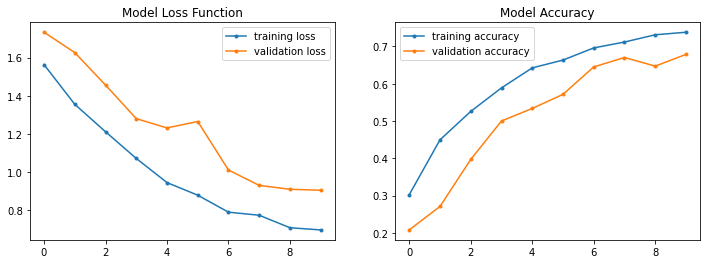

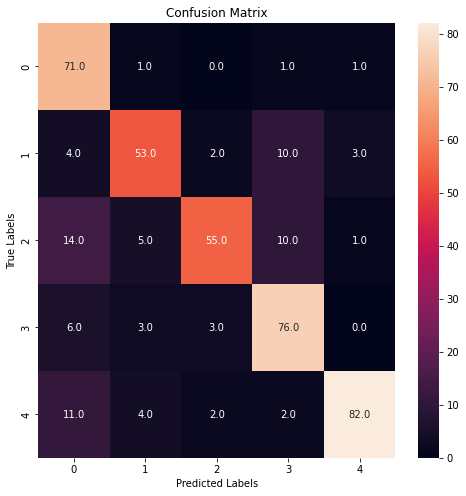

In [10]:
def make_plots(model_fit):
    history_df = pd.DataFrame(model_fit.history)
    plt.figure(figsize=(12,4))
    plt.subplot(1,2,1)
    plt.plot(history_df['loss'], '.', linestyle='solid', label='training loss')
    plt.plot(history_df['val_loss'], '.', linestyle='solid', label='validation loss')
    plt.title('Model Loss Function')
    plt.legend()
    plt.subplot(1,2,2)
    plt.plot(history_df['accuracy'], '.', linestyle='solid', label='training accuracy')
    plt.plot(history_df['val_accuracy'], '.', linestyle='solid', label='validation accuracy')
    plt.title('Model Accuracy')
    plt.legend();

def getPredTestClasses(model, X_test):
    y_pred = model.predict(X_test)
    # Converting prediction classes from one hot encoding to list
    # Argmax returns the position of the largest value
    y_pred_classes = np.argmax(y_pred, axis = 1)
    # Convert test labels from one hot encoding to list
    y_test_classes = np.argmax(y_test, axis = 1)
    return y_test_classes,y_pred_classes

def make_conf_matrix(y_test_classes,y_pred_classes):
    # Create the confusion matrix
    confmx = confusion_matrix(y_test_classes, y_pred_classes)
    f, ax = plt.subplots(figsize = (8,8))
    sns.heatmap(confmx, annot=True, fmt='.1f', ax = ax)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show();

make_plots(fit)
y_test_classes,y_pred_classes= getPredTestClasses(model, X_test)
make_conf_matrix(y_test_classes,y_pred_classes)

In [11]:
def create_label_key(y,data):
    dic={}
    for s in np.arange(0, len(reptiles), 100, dtype=int):
        key_value=data["target"][s]
        key=np.where(y[s] == 1)[0][0]
        dic[key]=key_value
    return dic

predicted=pd.DataFrame({"True":y_test_classes,"Pred":y_pred_classes})

# change classes to actual labels
label_key = create_label_key(y,reptiles)
predicted=predicted.replace({"True": label_key,"Pred":label_key})

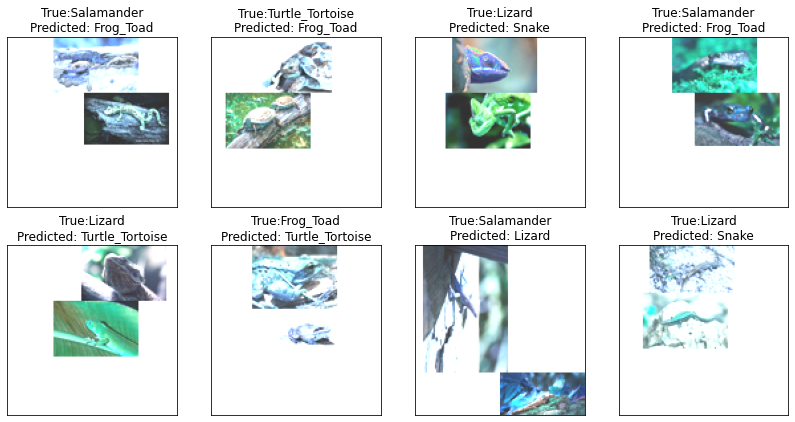

In [12]:
def show_sample_misclassified(predicted):
    misclassified=predicted.loc[~(predicted['True'] == predicted['Pred'])]
    indices = sample(misclassified.index.to_list(),8)
    i = 1
    plt.figure(figsize=(14,7))
    for each in indices:
        plt.subplot(2,4,i)
        plt.imshow(Image.fromarray(X_test[each]))
        plt.title("True:"+str(misclassified['True'].loc[each])+"\nPredicted: "+str(misclassified['Pred'].loc[each]))
        plt.xticks([])
        plt.yticks([])
        i += 1

show_sample_misclassified(predicted)

14/14 [==============================] - 11s 814ms/step


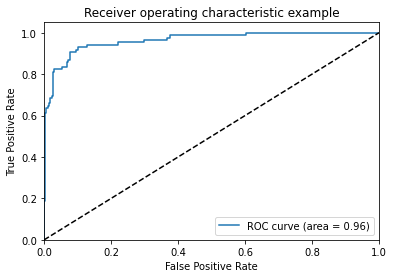

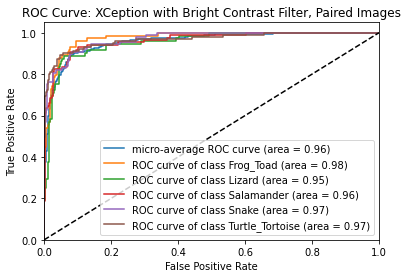

In [13]:
n_classes=reptiles["target"].nunique()
y_score=model.predict(X_test)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Plot of a ROC curve for a specific class
plt.figure()
plt.plot(fpr[2], tpr[2], label='ROC curve (area = %0.2f)' % roc_auc[2])
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

# Plot ROC curve
plt.figure()
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label='ROC curve of class {0} (area = {1:0.2f})'
                                   ''.format(label_key.get(i), roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve: XCeption with Bright Contrast Filter, Paired Images')
plt.legend(loc="lower right")
plt.show()